# Bibliotecas, Importação dos dados, Limpeza e Engenharia de Features

In [ ]:
# --- BLOCO 1: Configuração e Preparação dos Dados ---

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

Etapa 1 – Exploração e Preparação dos Dados

In [ ]:
# 1. Carregamento e inspeção inicial

url = 'https://drive.google.com/uc?export=download&id=1rVlcI0TRs5ADXAoybbMuiF-Rdpuykg3_'

# Lendo o arquivo CSV e mantendo ['obj_ID', 'spec_obj_ID'] como string
df = pd.read_csv(url, dtype={'obj_ID': str, 'spec_obj_ID': str})

display(df.head())

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1237660961327743232,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6543777369295181824,GALAXY,0.634794,5812,56354,171
1,1237664879951151360,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,11760142036707334144,GALAXY,0.779136,10445,58158,427
2,1237660961330430208,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5152200256025548800,GALAXY,0.644195,4576,55592,299
3,1237663478724297984,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,10301071412954421248,GALAXY,0.932346,9149,58039,775
4,1237680272041378048,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6891864880783316992,GALAXY,0.116123,6121,56187,842


In [ ]:
# 2. Tratamento de dados: Limpeza de Dados (Data Cleaning)

# Remover colunas de ID que não são features (metadados)
cols_to_drop = ['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'plate', 'MJD', 'fiber_ID', 'alpha', 'delta']
df = df.drop(columns=cols_to_drop, errors='ignore')

# Remover linhas com valores de erro (-9999)
df = df[df['u'] != -9999]
df = df[df['g'] != -9999]
df = df[df['z'] != -9999]

In [ ]:
# 3. Engenharia de Features (Feature Engineering)

# Transformar magnitudes brutas em "Cores Astronômicas" (Diferenças de magnitude)
# Isso ajuda os modelos a entenderem a física do objeto (temperatura)
df['u_g'] = df['u'] - df['g']
df['g_r'] = df['g'] - df['r']
df['r_i'] = df['r'] - df['i']
df['i_z'] = df['i'] - df['z']

# Selecionar apenas as features finais e o alvo
features = ['u_g', 'g_r', 'r_i', 'i_z', 'redshift']
target = 'class'

X = df[features]
y = df[target]

print(f"Dimensões finais do dataset: {df.shape}")
print(f"Classes encontradas: {y.unique()}")



Dimensões finais do dataset: (99999, 11)
Classes encontradas: ['GALAXY' 'QSO' 'STAR']


In [ ]:
# 4. Pré-processamento para Modelos (Encoding e Scaling)

# A) Codificação do Alvo (String -> Número)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print(f"Mapeamento de Classes: {dict(zip(class_names, le.transform(class_names)))}")

# B) Divisão Treino/Teste
# Manteremos o padrão 80/20 com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# C) Normalização/Padronização (StandardScaler)
# EM INTELIGÊNCIA COMPUTACIONAL ISSO É CRUCIAL!
# Especialmente para a Regressão Logística convergir corretamente.
scaler = StandardScaler()

# Ajustar (fit) apenas no treino e transformar ambos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDados prontos para o treinamento dos modelos.")
print(f"X_train shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")

Mapeamento de Classes: {'GALAXY': np.int64(0), 'QSO': np.int64(1), 'STAR': np.int64(2)}

Dados prontos para o treinamento dos modelos.
X_train shape: (79999, 5)
y_train shape: (79999,)


# Vizualização de dados

--- 1. Mapa de Calor de Correlação (Correlation Heatmap) ---


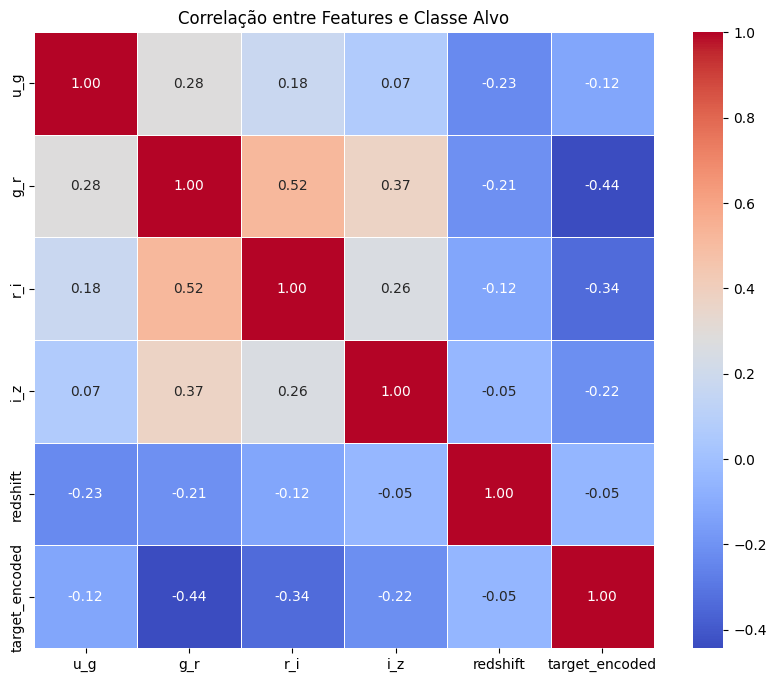


--- 2. Histogramas (Distribuição das Variáveis) ---


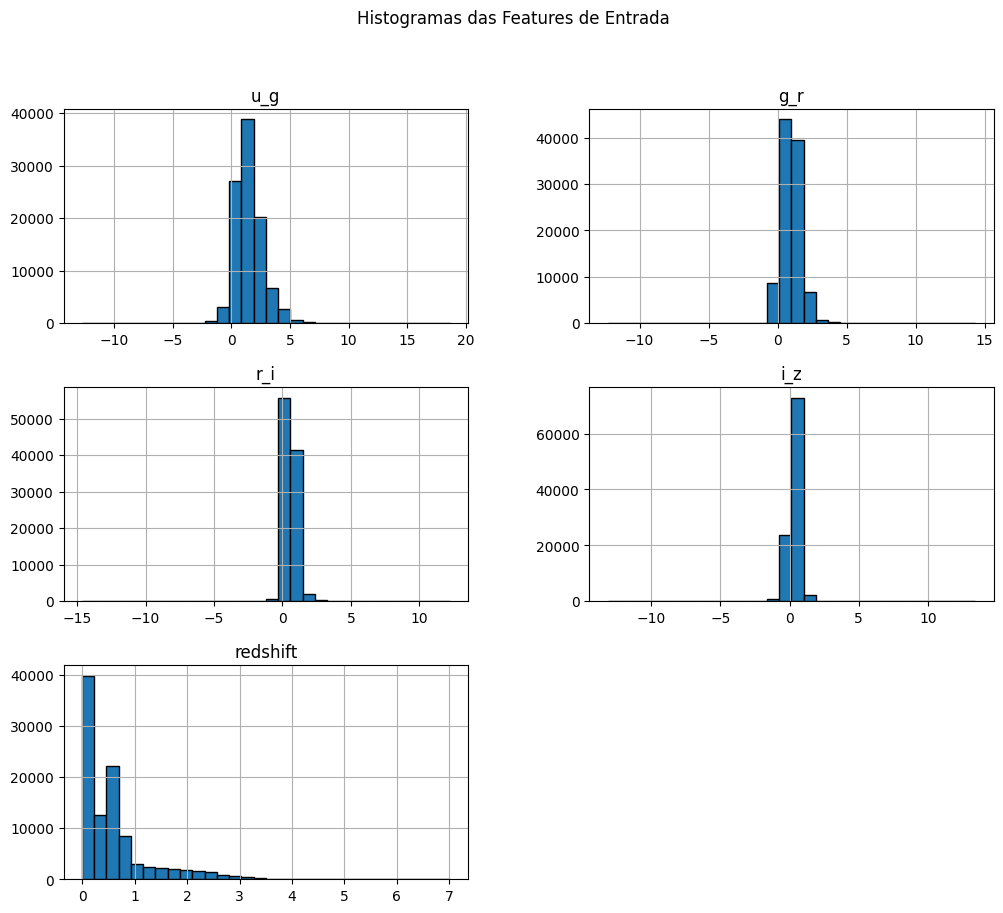


--- 3. Pairplot (Dispersão com Separação de Classes) ---


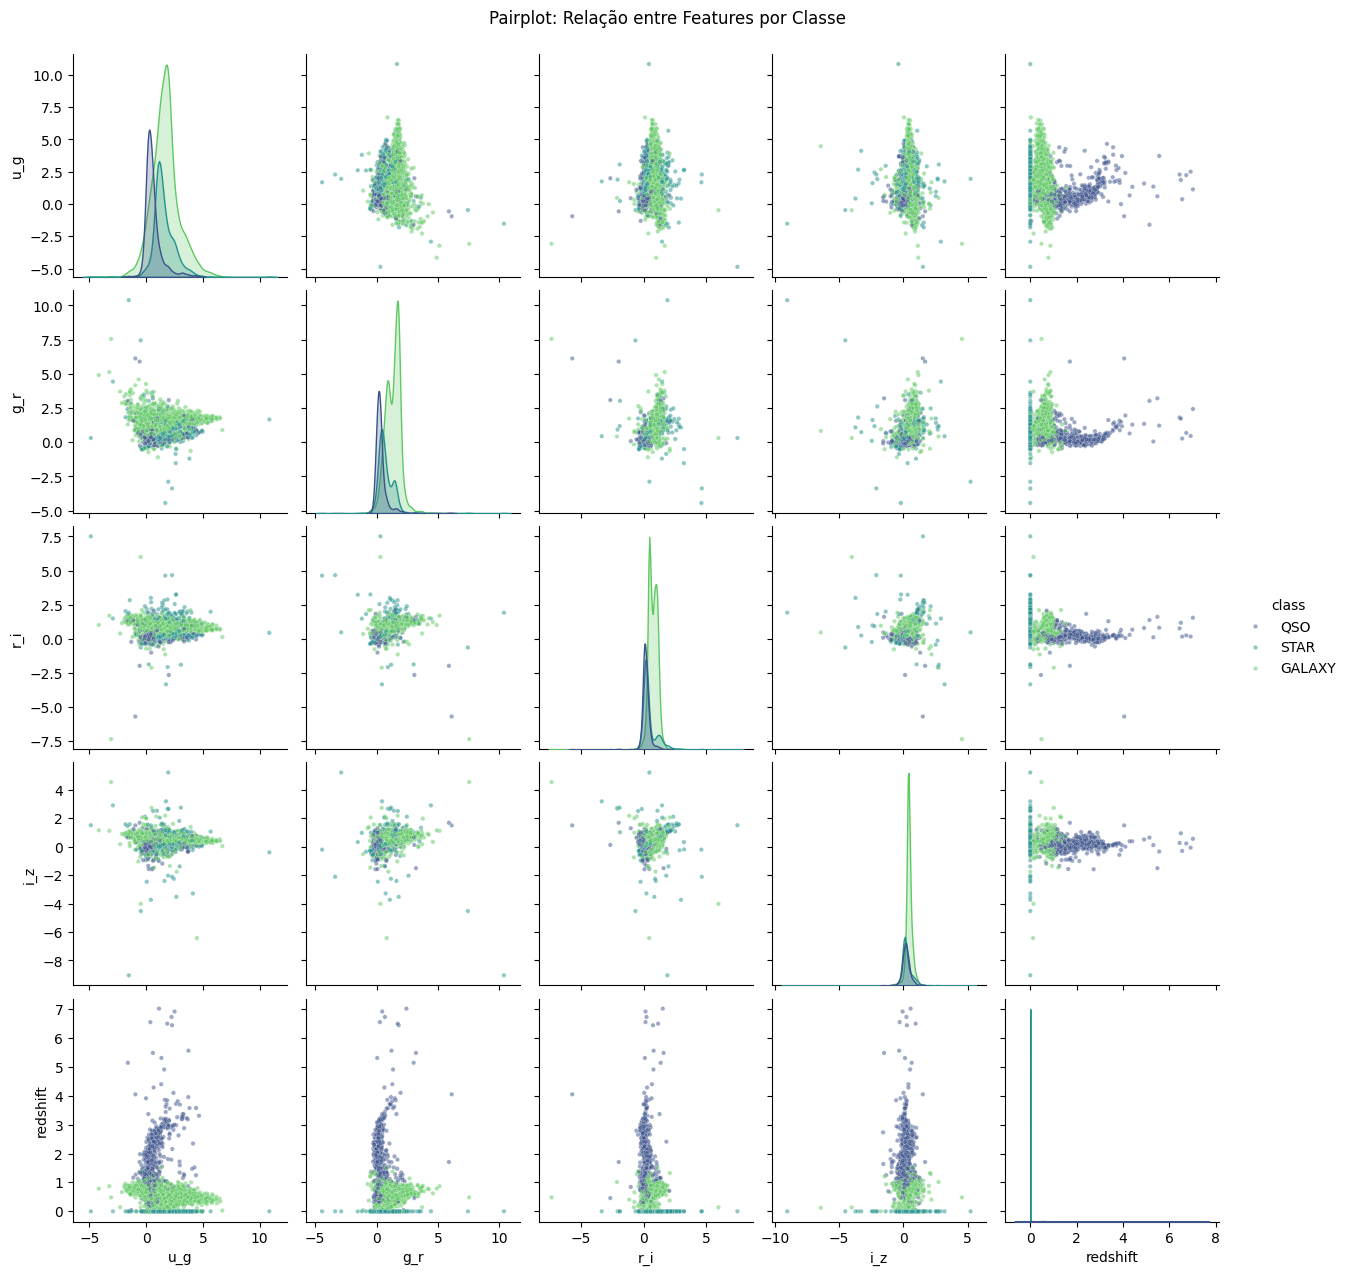


--- 4. Boxplot do Redshift (Feature Principal) ---


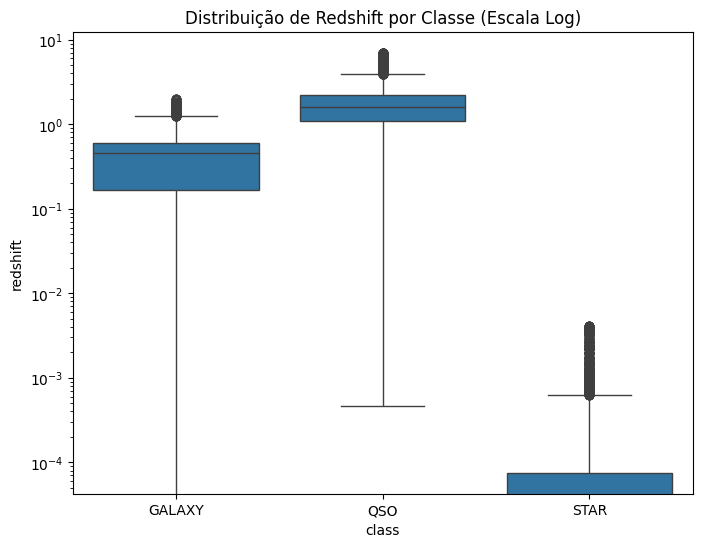

In [ ]:
# --- BLOCO 1.5: Visualizações Exploratórias (EDA) ---

# Vamos usar uma amostra para as visualizações pesadas (como Pairplot)
# para não travar o Colab com 100 mil pontos.
df_sample = df.sample(n=5000, random_state=42)

print("--- 1. Mapa de Calor de Correlação (Correlation Heatmap) ---")
# Mostra quais variáveis estão relacionadas entre si e com o alvo
# Precisamos codificar a classe temporariamente para ver a correlação com ela
df_corr = df[features].copy()
df_corr['target_encoded'] = y_encoded # Usando o y codificado do Bloco 1

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlação entre Features e Classe Alvo")
plt.show()

print("\n--- 2. Histogramas (Distribuição das Variáveis) ---")
# Mostra como os dados estão espalhados (se são normais, se têm cauda, etc.)
df[features].hist(bins=30, figsize=(12, 10), edgecolor='black')
plt.suptitle("Histogramas das Features de Entrada")
plt.show()

print("\n--- 3. Pairplot (Dispersão com Separação de Classes) ---")
# O gráfico mais importante: mostra se as classes são separáveis visualmente.
# Usamos a amostra para ser rápido.
sns.pairplot(df_sample, vars=features, hue='class', palette='viridis',
             plot_kws={'alpha': 0.5, 's': 10}) # alpha deixa transparente para ver sobreposição
plt.suptitle("Pairplot: Relação entre Features por Classe", y=1.02)
plt.show()

print("\n--- 4. Boxplot do Redshift (Feature Principal) ---")
# Como já sabemos que redshift é forte, vamos vê-lo isolado
plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='redshift', data=df)
plt.yscale('log') # Escala log porque os Quasares são muito distantes
plt.title("Distribuição de Redshift por Classe (Escala Log)")
plt.show()

# Treinamento e Comparação de Modelos

In [ ]:
# --- BLOCO 2: Treinamento e Avaliação Comparativa ---
# Import de Bibliotecas
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [ ]:
# Dicionário para guardar os resultados e comparar depois
resultados = {}

print("--- Iniciando Treinamento dos Modelos ---\n")

# 1. Regressão Logística (Modelo Linear)
# Usa dados SCALED (Normalizados)
print("1. Treinando Regressão Logística Multinomial...")
model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)

acc_lr = accuracy_score(y_test, y_pred_lr)
resultados['Regressão Logística'] = acc_lr
print(f"   Acurácia: {acc_lr:.4f}")
print("-" * 30)


# 2. Árvore de Decisão (Modelo Simbólico/Não-Linear)
# Usa dados ORIGINAIS (Árvores não precisam de escala)
print("2. Treinando Árvore de Decisão...")
model_dt = DecisionTreeClassifier(max_depth=5, random_state=42) # Limitando profundidade para evitar overfitting
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
resultados['Árvore de Decisão'] = acc_dt
print(f"   Acurácia: {acc_dt:.4f}")
print("-" * 30)


# 3. Random Forest (Inteligência Coletiva/Ensemble)
# Usa dados ORIGINAIS
print("3. Treinando Random Forest...")
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
resultados['Random Forest'] = acc_rf
print(f"   Acurácia: {acc_rf:.4f}")
print("=" * 30)




--- Iniciando Treinamento dos Modelos ---

1. Treinando Regressão Logística Multinomial...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


   Acurácia: 0.9509
------------------------------
2. Treinando Árvore de Decisão...
   Acurácia: 0.9748
------------------------------
3. Treinando Random Forest...
   Acurácia: 0.9793



Gerando Matrizes de Confusão...


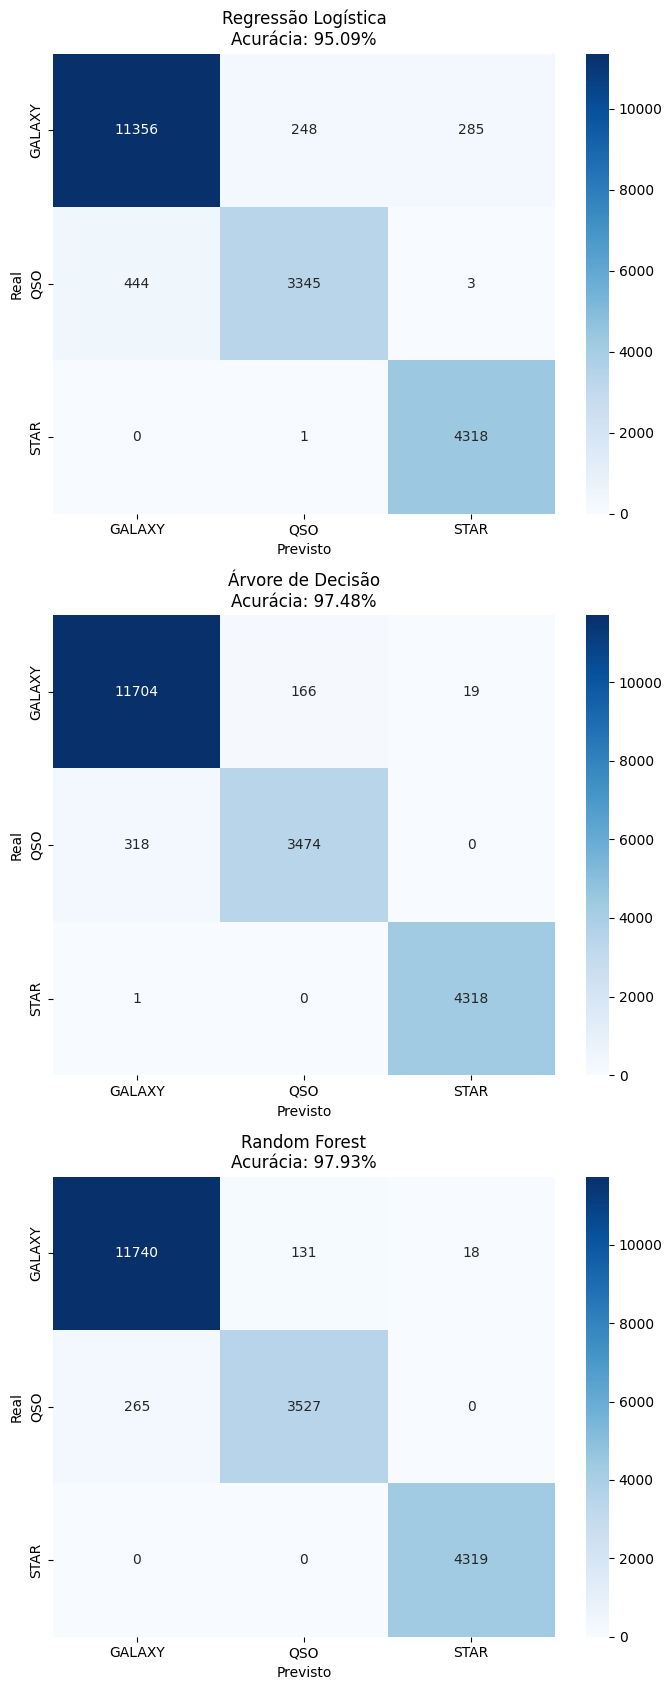


--- Resumo Final de Desempenho ---
                     Acurácia
Random Forest         0.97930
Árvore de Decisão     0.97480
Regressão Logística   0.95095


In [ ]:
# --- Visualização: Matrizes de Confusão Comparadas ---
print("\nGerando Matrizes de Confusão...")

fig, axes = plt.subplots(3, 1, figsize=(7, 17))

# Lista de modelos e previsões para o loop
modelos_para_plotar = [
    ('Regressão Logística', y_pred_lr),
    ('Árvore de Decisão', y_pred_dt),
    ('Random Forest', y_pred_rf)
]

for ax, (nome, preds) in zip(axes, modelos_para_plotar):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f'{nome}\nAcurácia: {resultados[nome]:.2%}')
    ax.set_xlabel('Previsto')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()

# Exibir Tabela Final de Acurácias
print("\n--- Resumo Final de Desempenho ---")
df_res = pd.DataFrame.from_dict(resultados, orient='index', columns=['Acurácia'])
print(df_res.sort_values('Acurácia', ascending=False))

In [ ]:
# --- BLOCO 2.5: Otimização de Hiperparâmetros (Grid Search) ---
# Teste - Provavelmente será substituidos pelos próximos blocos

from sklearn.model_selection import GridSearchCV

print("--- Iniciando Ajuste Fino de Hiperparâmetros (Tuning) ---")
print("Modelo escolhido para otimização: Árvore de Decisão\n")

# 1. Definir a "Grade" de parâmetros para testar
# O computador vai testar TODAS as combinações abaixo:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],       # Profundidades diferentes
    'criterion': ['gini', 'entropy'],           # Critérios de impureza diferentes
    'min_samples_leaf': [1, 2, 4]               # Mínimo de amostras na folha (evita overfitting)
}

# 2. Configurar o GridSearchCV
# cv=5 significa que ele vai usar validação cruzada (5 dobras) para cada teste
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Usa todos os núcleos do processador
    verbose=1
)

# 3. Rodar a busca (Isso treina dezenas de modelos!)
print("Buscando os melhores parâmetros...")
grid_search.fit(X_train, y_train)

# 4. Resultados
best_dt = grid_search.best_estimator_

print("\n--- Resultados da Otimização ---")
print(f"Melhores Parâmetros encontrados: {grid_search.best_params_}")
print(f"Melhor Acurácia na Validação (Treino): {grid_search.best_score_:.4f}")

# 5. Testar o Melhor Modelo nos dados de Teste (Prova Real)
y_pred_best = best_dt.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)

print(f"Acurácia no Conjunto de Teste (Otimizado): {acc_best:.4f}")

# Comparação com o modelo anterior (fixo)
print(f"Comparação: Modelo Fixo ({resultados['Árvore de Decisão']:.4f}) vs. Otimizado ({acc_best:.4f})")

--- Iniciando Ajuste Fino de Hiperparâmetros (Tuning) ---
Modelo escolhido para otimização: Árvore de Decisão

Buscando os melhores parâmetros...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

--- Resultados da Otimização ---
Melhores Parâmetros encontrados: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4}
Melhor Acurácia na Validação (Treino): 0.9731
Acurácia no Conjunto de Teste (Otimizado): 0.9741
Comparação: Modelo Fixo (0.9748) vs. Otimizado (0.9741)


In [ ]:
# --- BLOCO 3: Otimização de Hiperparâmetros (Grid Search Completo) ---

from sklearn.model_selection import GridSearchCV, cross_val_score

print("--- Iniciando Otimização de Hiperparâmetros para TODOS os modelos ---")

# 1. Otimização da Regressão Logística
print("\n1. Otimizando Regressão Logística...")
param_grid_lr = {
    'model__C': [0.1, 1, 10],           # Força da regularização (menor = mais forte)
    'model__solver': ['lbfgs', 'saga']  # Algoritmos de otimização
}
# Recriando o pipeline para o GridSearch
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(multi_class='multinomial', max_iter=5000, random_state=42))
])

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train) # O pipeline cuida do scaling internamente
best_lr = grid_lr.best_estimator_
print(f"Melhores parâmetros (LR): {grid_lr.best_params_}")
print(f"Melhor Acurácia (Treino/Validação): {grid_lr.best_score_:.4f}")


# 2. Otimização da Árvore de Decisão (Já fizemos, mas consolidando)
print("\n2. Otimizando Árvore de Decisão...")
param_grid_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
print(f"Melhores parâmetros (DT): {grid_dt.best_params_}")
print(f"Melhor Acurácia (Treino/Validação): {grid_dt.best_score_:.4f}")


# 3. Otimização do Random Forest
print("\n3. Otimizando Random Forest (Isso pode demorar um pouco)...")
param_grid_rf = {
    'n_estimators': [50, 100],       # Número de árvores
    'max_depth': [10, 20, None],     # Profundidade máxima
    'min_samples_split': [2, 5]      # Mínimo para dividir um nó
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print(f"Melhores parâmetros (RF): {grid_rf.best_params_}")
print(f"Melhor Acurácia (Treino/Validação): {grid_rf.best_score_:.4f}")

--- Iniciando Otimização de Hiperparâmetros para TODOS os modelos ---

1. Otimizando Regressão Logística...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Melhores parâmetros (LR): {'model__C': 10, 'model__solver': 'lbfgs'}
Melhor Acurácia (Treino/Validação): 0.9547

2. Otimizando Árvore de Decisão...
Melhores parâmetros (DT): {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
Melhor Acurácia (Treino/Validação): 0.9728

3. Otimizando Random Forest (Isso pode demorar um pouco)...
Melhores parâmetros (RF): {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Melhor Acurácia (Treino/Validação): 0.9772


In [ ]:
# --- BLOCO 4: Avaliação Final e Validação Cruzada (Sprint 05) ---

from sklearn.metrics import precision_score, recall_score, f1_score

print("--- Avaliação Final dos Melhores Modelos (Dados de Teste) ---\n")

# Função auxiliar para imprimir métricas de classificação
# Nota: Substituímos MAE/RMSE/R2 (Regressão) por Acurácia/Precision/Recall/F1 (Classificação)
def avaliar_modelo(nome, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    # 'weighted' calcula a média ponderada pelo número de amostras de cada classe
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Modelo: {nome}")
    print(f"  Acurácia:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print("-" * 30)

# Avaliar os modelos otimizados
avaliar_modelo("Regressão Logística (Otimizada)", best_lr, X_test, y_test) # O pipeline lida com X_test normal vs scaled
avaliar_modelo("Árvore de Decisão (Otimizada)", best_dt, X_test, y_test)
avaliar_modelo("Random Forest (Otimizado)", best_rf, X_test, y_test)


print("\n--- Validação Cruzada Robusta (Cross-Validation k=5) ---")
print("Calculando média e desvio padrão da acurácia em 5 dobras...")

# Função para validação cruzada
def validacao_cruzada_stats(nome, modelo, X, y):
    scores = cross_val_score(modelo, X, y, cv=5, scoring='accuracy', n_jobs=-1)
    print(f"{nome}:")
    print(f"  Média: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Importante: Regressão Logística precisa do Pipeline para escalar dentro de cada dobra
validacao_cruzada_stats("Regressão Logística", best_lr, X_train, y_train)
validacao_cruzada_stats("Árvore de Decisão", best_dt, X_train, y_train)
validacao_cruzada_stats("Random Forest", best_rf, X_train, y_train)

--- Avaliação Final dos Melhores Modelos (Dados de Teste) ---

Modelo: Regressão Logística (Otimizada)
  Acurácia:  0.9577
  Precision: 0.9573
  Recall:    0.9577
  F1-Score:  0.9573
------------------------------
Modelo: Árvore de Decisão (Otimizada)
  Acurácia:  0.9747
  Precision: 0.9746
  Recall:    0.9747
  F1-Score:  0.9746
------------------------------
Modelo: Random Forest (Otimizado)
  Acurácia:  0.9796
  Precision: 0.9795
  Recall:    0.9796
  F1-Score:  0.9794
------------------------------

--- Validação Cruzada Robusta (Cross-Validation k=5) ---
Calculando média e desvio padrão da acurácia em 5 dobras...
Regressão Logística:
  Média: 0.9547 (+/- 0.0027)
Árvore de Decisão:
  Média: 0.9728 (+/- 0.0030)
Random Forest:
  Média: 0.9772 (+/- 0.0021)



--- Tabela de Importância ---
    Feature  Importance
4  redshift    0.611094
2       r_i    0.163944
1       g_r    0.131339
0       u_g    0.048612
3       i_z    0.045011


/tmp/ipython-input-2587139113.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


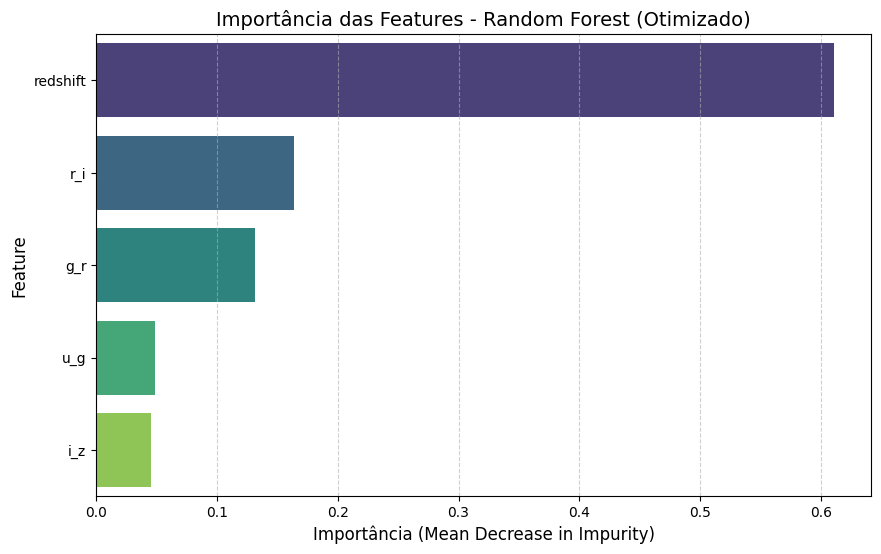

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- CÓDIGO PARA GERAR GRÁFICO DE IMPORTÂNCIA DAS FEATURES ---

# 1. Extrair as importâncias do modelo treinado (best_rf ou model_rf)
# Certifique-se de que 'best_rf' é o nome da sua variável do modelo Random Forest
importances = best_rf.feature_importances_

# 2. Criar um DataFrame para organizar os dados
# 'features' deve ser a lista com os nomes das colunas: ['u_g', 'g_r', 'r_i', 'i_z', 'redshift']
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Tabela de Importância ---")
print(feature_importance_df)

# 3. Gerar o Gráfico de Barras
plt.figure(figsize=(10, 6))

# Criar o barplot
sns.barplot(
    data=feature_importance_df,
    x='Importance',
    y='Feature',
    palette='viridis' # Escolha de cores moderna
)

# 4. Personalizar o Gráfico
plt.title('Importância das Features - Random Forest (Otimizado)', fontsize=14)
plt.xlabel('Importância (Mean Decrease in Impurity)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6) # Grid vertical suave

# 5. Salvar e Mostrar
plt.savefig('feature_importance_rf_final.png', dpi=300, bbox_inches='tight')
plt.show()